In [ ]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
    
    
### DATA STRUCTURE
### Rewriting all data into an array [beta, ek, vk, [G, S]]
PATH = "../data/U2c0_b30_N250000.jld2"
f = h5py.File(PATH, 'r')

### Unique parameters
unique_ek = []
unique_vk = [] 
unique_beta = [] 
for n,para in enumerate(f["Set1"]["Parameters"]):
    if para[0] not in unique_ek:
        unique_ek.append(para[0])
    if para[2] not in unique_vk:
        unique_vk.append(para[2])
    if para[6] not in unique_beta:
        unique_beta.append(para[6])
unique_beta = np.array(unique_beta)
unique_ek = np.array(unique_ek)
unique_vk = np.array(unique_vk)

### Book-keeping between indices of 'data' and actual parameter [beta, ek, vk]
idx_to_para = np.zeros((unique_beta.shape[0], unique_ek.shape[0], unique_vk.shape[0], 3))
n = 0
for b, beta in enumerate(unique_beta):    
    for e, ek in enumerate(unique_ek):    
        for v, vk in enumerate(unique_vk):    
            idx_to_para[b,e,v] = np.array([beta, ek, vk])

### Array
data = np.zeros((unique_beta.shape[0], unique_ek.shape[0], unique_vk.shape[0], 2, 1000), dtype=complex)
for n,para in enumerate(f["Set1"]["Parameters"]):
    # jld2 Format fksp complex numbers and stores them into tuples.
    # g = []
    # s = []
    g = f["Set1"]["GImp"][n,:]['re'] + 1j*f["Set1"]["GImp"][n,:]['im']
    # for gg in f["Set1"]["GImp"][n,:]:
    #     g.append(gg[0] + 1j*gg[1])
    g = np.array(g)
    s = f["Set1"]["SImp"][n,:]['re'] + 1j*f["Set1"]["SImp"][n,:]['im']
    # for ss in f["Set1"]["SImp"][n,:]:
    #     s.append(ss[0] + 1j*ss[1])
    s = np.array(s)
    idx = np.argwhere((idx_to_para == np.array([para[6],  para[0], para[2]])).all(-1))[0]
    data[idx[0],idx[1],idx[2],0] = g
    data[idx[0],idx[1],idx[2],1] = s
    
    if n%1000==0:
        print(n)


# data = np.zeros((unique_beta.shape[0], unique_ek.shape[0], unique_vk.shape[0], 2, 1000), dtype=complex)
# for n,para in enumerate(f["Set1"]["Parameters"]):
#     # jld2 Format fksp complex numbers and stores them into tuples.
#     # g = []
#     # s = []
#     g = np.zeros((f["Set1"]["GImp"].shape), dtype=complex)
#     # dd = np.array(f["Set1"]["GImp"][:,:][1], dtype=complex)
    
#     # print(dd[0,0].shape)
#     print(np.array(f["Set1"]["GImp"][:,:]).shape)
#     # for n in 
#     # g[n] = f["Set1"]["GImp"][n,:][0] + 1j*f["Set1"]["GImp"][n,:][1]

#     # for gg in f["Set1"]["GImp"][n,:]:
#     #     print(gg)
#     #     # g.append(gg[0] + 1j*gg[1])
#     #     print(gg[0], gg[1])
#     #     break
#     # # g = np.array(g)
#     # print(f["Set1"]["GImp"].shape)
#     # print(f["Set1"]["GImp"][0,0])
#     break
#     # for ss in f["Set1"]["SImp"][n,:]:
#     #     s.append(ss[0] + 1j*ss[1])
#     # s = np.array(s)
#     # idx = np.argwhere((idx_to_para == np.array([para[6],  para[0], para[2]])).all(-1))[0]
#     # data[idx[0],idx[1],idx[2],0] = g
#     # data[idx[0],idx[1],idx[2],1] = s
    
#     # if n%10000==0:
#     #     print(n)

# d1 = f["Set1"]["GImp"][:,0]
# d2 = f["Set1"]["GImp"][0,:]
# d3 = np.array(f["Set1"]["GImp"])

# print(d3[:,:]['im'].shape)

# data = np.zeros((250000, 1000), dtype=complex)
# data = f["Set1"]["GImp"]['re'] + 1j*f["Set1"]["GImp"]['im']
# # for n in range(0,1000):
# #     print(d3[:,n].shape)
# #     data[:,n] = np.array(d3[:,n])



In [9]:
## Sigma Trend
## If gradient of sigma is positive at origin -> Insulator
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
# f.close()
# f.close()

from scipy.optimize import curve_fit

def fit_ImSigma_3(iw, gamma, alpha, beta, delta):
    ImSigma = gamma + alpha * iw + beta * iw**2 + delta * iw**3
    return ImSigma

data_split = {}
data_split["met"] = {}
data_split["iso"] = {}
phase = np.zeros((500,500))
grad = np.zeros((500,500))
fitpoints = 5
ftp = np.linspace(0,fitpoints,fitpoints, dtype=int)
iv = (2*ftp + 1) / beta * np.pi

### SET THIS PARAMETER TO DISTINGUISH TRAIN/VALIDATE
# Trend = "Sigma"
Trend = "G"

for b in range(0,1): # Currently only a single beta in each file (Julia script does that)
    met = []
    iso = []
    for n1 in range(0,500):
        for n2 in range(0,500):
            # d = data[b,n1,n2,0,1].imag - data[b,n1,n2,0,0].imag
            # grad[n1,n2] = d

            if Trend == "G":
                giv = (data[b,n1,n2,0,0:fitpoints]).imag
                popt2, pcov2 = curve_fit(fit_ImSigma_3, iv, giv)
                d = popt2[1]
                grad[n1,n2] = d
                if d > 0:
                    phase[n1,n2] = -1
                    met.append([n1,n2])
                if d < 0:
                    phase[n1,n2] = 1
                    iso.append([n1,n2])
            if Trend == "Sigma":
                siv = (data[b,n1,n2,1,0:fitpoints]).imag
                popt2, pcov2 = curve_fit(fit_ImSigma_3, iv, siv)
                d = popt2[1]
                grad[n1,n2] = d
                if d < 0:
                    phase[n1,n2] = -1
                    met.append([n1,n2])
                if d > 0:
                    phase[n1,n2] = 1
                    iso.append([n1,n2])



    print(idx_to_para.shape)
    met = np.array(met)
    iso = np.array(iso)
    print(iso.shape)
    data_split["iso"]["parameters"] = {}
    data_split["met"]["parameters"] = {}
    data_split["iso"]["data"] = {}
    data_split["met"]["data"] = {}
    data_split["iso"]["parameters"][str(unique_beta[b])] = idx_to_para[b,iso[:,0],iso[:,1]]
    data_split["met"]["parameters"][str(unique_beta[b])] = idx_to_para[b,met[:,0],met[:,1]]
    data_split["iso"]["data"][str(unique_beta[b])] = data[b,iso[:,0],iso[:,1]]
    data_split["met"]["data"][str(unique_beta[b])] = data[b,met[:,0],met[:,1]]

f = h5py.File(f"../data/{Trend}Trend/U2c0_b{int(unique_beta[0])}_N250000.hdf5", "w")
for b in unique_beta:
    f.create_dataset(f'metallic/data/{str(b)}', data = data_split["met"]["data"][str(b)])
    f.create_dataset(f'metallic/parameters/{str(b)}', data = data_split["met"]["parameters"][str(b)])
    f.create_dataset(f'insulating/data/{str(b)}', data = data_split["iso"]["data"][str(b)])
    f.create_dataset(f'insulating/parameters/{str(b)}', data = data_split["iso"]["parameters"][str(b)])
f.close()

(1, 500, 500, 3)
(50666, 2)


In [12]:
## STRATEGY 3
## If gradient of sigma is positive at origin -> Insulator

from scipy.optimize import curve_fit

def fit_ImSigma_3(iw, gamma, alpha, beta, delta):
    ImSigma = -gamma - alpha * iw - beta * iw**2 - delta * iw**3
    return ImSigma

phase = np.zeros((500,500))
grad = np.zeros((500,500))
fitpoints = 15
ftp = np.linspace(0,fitpoints,fitpoints, dtype=int)
iv = (2*ftp - 1) / beta * np.pi

Trend = "Sigma"
# Trend = "G"

for b in range(0,1): # Currently only a single beta in each file (Julia script does that)
    met = []
    iso = []
    for n1 in range(0,500):
        for n2 in range(0,500):
            # d = data[b,n1,n2,0,1].imag - data[b,n1,n2,0,0].imag
            # grad[n1,n2] = d

            if Trend == "G":
                giv = (data[b,n1,n2,0,0:fitpoints]).imag
                popt2, pcov2 = curve_fit(fit_ImSigma_3, iv, giv)
                d = popt2[1]
                grad[n1,n2] = d
                if d > 0:
                    phase[n1,n2] = -1
                if d < 0:
                    phase[n1,n2] = 1
            if Trend == "Sigma":
                siv = (data[b,n1,n2,1,0:fitpoints]).imag
                popt2, pcov2 = curve_fit(fit_ImSigma_3, iv, siv)
                d = popt2[1]
                grad[n1,n2] = d
                if d < 0:
                    phase[n1,n2] = -1
                if d > 0:
                    phase[n1,n2] = 1

transition = np.zeros(500) - 1
transition_proximity = np.zeros((500,500)) - 1

ref = phase[n1,0]
for n1 in range(0,500):
    for n2 in range(0,500):
        if (ref-phase[n1,n2])!=0:
            transition[n1] = n2
            ref = phase[n1,n2]

data_split = {}
data_split["metiso"] = {}
data_split["transprox"] = {}
data_split["metiso"]["parameters"] = []
data_split["transprox"]["parameters"] = []
data_split["metiso"]["data"] = []
data_split["transprox"]["data"] = []

for n1 in range(0,500):
    if transition[n1]!=-1:
        for t2 in range(-3,4):
            nt2 = int(transition[n1]+t2)
            if (nt2 > -1) and (nt2 < 500):
                transition_proximity[n1,nt2] = 1

for n1 in range(0,500):
    for n2 in range(0,500):
        if transition_proximity[n1,n2] == 1:
            data_split["transprox"]["data"].append(data[0,n1,n2])
            data_split["transprox"]["parameters"].append(idx_to_para[0,n1,n2])
        else:
            data_split["metiso"]["data"].append(data[0,n1,n2])
            data_split["metiso"]["parameters"].append(idx_to_para[0,n1,n2])

data_split["transprox"]["data"] = np.array(data_split["transprox"]["data"])
data_split["transprox"]["parameters"] = np.array(data_split["transprox"]["parameters"])
data_split["metiso"]["data"] = np.array(data_split["metiso"]["data"])
data_split["metiso"]["parameters"] = np.array(data_split["metiso"]["parameters"])
                
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
f = h5py.File(f"../data/{Trend}Trans/U2c0_b{int(unique_beta[0])}_N250000.hdf5", "w")
for b in unique_beta:
    f.create_dataset(f'transprox/data/{str(b)}', data = data_split["transprox"]["data"])
    f.create_dataset(f'transprox/parameters/{str(b)}', data = data_split["transprox"]["parameters"])
    f.create_dataset(f'metiso/data/{str(b)}', data = data_split["metiso"]["data"])
    f.create_dataset(f'metiso/parameters/{str(b)}', data = data_split["metiso"]["parameters"])
f.close()

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15,5))
p = ax[0].imshow(phase[:,:].real, aspect="auto", cmap="jet")
ax[0].set_xlabel("ek")
ax[0].set_ylabel("vk")
ax[0].set_title("Metall/Insulating")
# fig.colorbar(p, ax=ax[0])


p = ax[1].imshow(grad[:,:].real, aspect="auto", cmap="jet")
ax[1].set_xlabel("ek")
ax[1].set_ylabel("vk")
ax[1].set_title("Transition Region")
fig.colorbar(p, ax=ax[1])

# p = ax[1].imshow(grad[:,:].real, aspect="auto", cmap="jet")
# ax[1].set_xlabel("ek")
# ax[1].set_ylabel("vk")
# ax[1].set_title("Sigma Gradient")
# fig.colorbar(p, ax=ax[1])



In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15,5))
p = ax[0].imshow(phase[:,:].real, aspect="auto", cmap="jet")
ax[0].set_xlabel("ek")
ax[0].set_ylabel("vk")
ax[0].set_title("Metall/Insulating")
# fig.colorbar(p, ax=ax[0])


p = ax[1].imshow(grad[:,:].real, aspect="auto", cmap="jet")
ax[1].set_xlabel("ek")
ax[1].set_ylabel("vk")
ax[1].set_title("Transition Region")
fig.colorbar(p, ax=ax[1])

# p = ax[1].imshow(grad[:,:].real, aspect="auto", cmap="jet")
# ax[1].set_xlabel("ek")
# ax[1].set_ylabel("vk")
# ax[1].set_title("Sigma Gradient")
# fig.colorbar(p, ax=ax[1])



In [4]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os


PATH_TRAIN = "/gpfs/data/fs72150/springerd/Projects/LuttingerWard_from_ML/data/SigmaTrend/U2c0_b30_N250000.hdf5"
TRAINDATA = "metallic/data/30.0"
VALIDATIONDATA = "metallic/data/30.0"

sf = h5py.File(PATH_TRAIN, 'r')
print(sf.keys())
Sdata = sf["metallic/data/30.0"]


PATH_TRAIN = "/gpfs/data/fs72150/springerd/Projects/LuttingerWard_from_ML/data/SigmaTrans/U2c0_b30_N250000.hdf5"
sf = h5py.File(PATH_TRAIN, 'r')
print(sf.keys())


<KeysViewHDF5 ['insulating', 'metallic']>
<KeysViewHDF5 ['metiso', 'transprox']>


In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os


PATH_TRAIN = "/gpfs/data/fs72150/springerd/Projects/LuttingerWard_from_ML/data/GTrend/U2c0_b30_N250000.hdf5"
TRAINDATA = "metallic/data/30.0"
VALIDATIONDATA = "metallic/data/30.0"

gf = h5py.File(PATH_TRAIN, 'r')
Gdata = gf["metallic/data/30.0"]


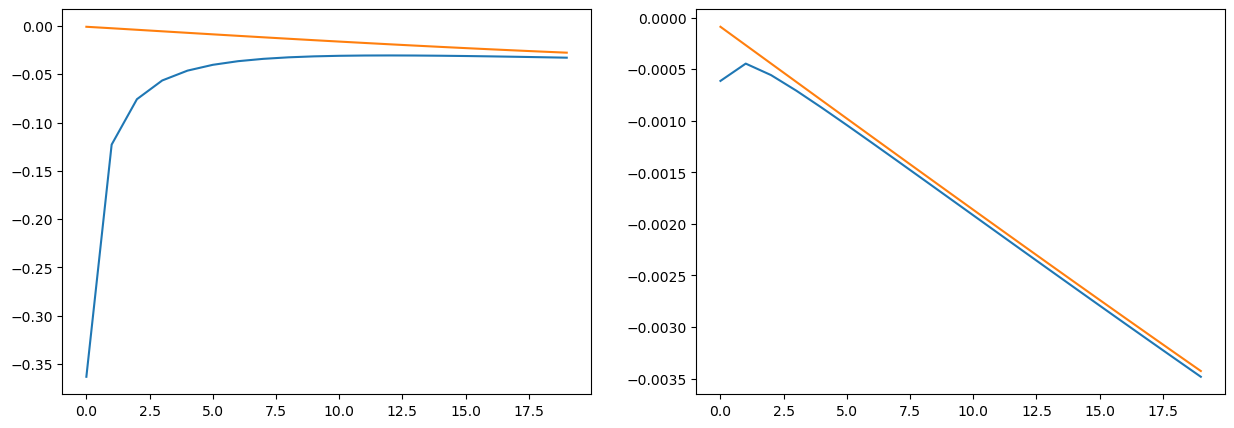

In [3]:
n = 1500
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15,5))
fign = 0 
ax[fign].plot(Gdata[n,0,:20].imag)
ax[fign].plot(Sdata[n,0,:20].imag)

fign = 1
ax[fign].plot(Gdata[n,1,:20].imag)
ax[fign].plot(Sdata[n,1,:20].imag)

# for n in range(0,100):
#     if np.sum(Gdata[n,0,:].imag-Sdata[n,0,:].imag)!=0:
#         fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15,5))
#         fign = 0 
#         ax[fign].plot(Gdata[n,0,:20].imag)
#         ax[fign].plot(Sdata[n,0,:20].imag)
        
#         fign = 1
#         ax[fign].plot(Gdata[n,1,:20].imag)
#         ax[fign].plot(Sdata[n,1,:20].imag)
#         break

# print(n)

# print(Gdata.shape, Sdata.shape)


In [4]:
print(Gdata.shape, Sdata.shape)

gf.close()
sf.close()

(7982, 2, 200) (3040, 2, 200)


In [3]:
import torch
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os


PATH_TRAIN = "/gpfs/data/fs72150/springerd/Projects/LuttingerWard_from_ML/data/GTrend/U2c0_b30.0_1.hdf5"
TRAINDATA = "insulating/data/30.0"
VALIDATIONDATA = "insulating/data/30.0"
gf = h5py.File(PATH_TRAIN, 'r')
Gdata = gf["insulating/data/30.0"]

PATH_TRAIN = "/gpfs/data/fs72150/springerd/Projects/LuttingerWard_from_ML/data/SigmaTrend/U2c0_b30.0_1.hdf5"
TRAINDATA = "insulating/data/30.0"
VALIDATIONDATA = "insulating/data/30.0"
sf = h5py.File(PATH_TRAIN, 'r')
Sdata = sf["insulating/data/30.0"]

PATH_TRAIN = "/gpfs/data/fs72150/springerd/Projects/LuttingerWard_from_ML/data/batch_1_new.hdf5"
bf = h5py.File(PATH_TRAIN, 'r')
Bdata = bf["/data/30"]

# PATH_TRAIN = "/gpfs/data/fs72150/springerd/Projects/LuttingerWard_from_ML/data/batch1.hdf5"
# bf = h5py.File(PATH_TRAIN, 'r')
# # print(bf['Set1']['GImp'].shape)
# # print(bf['Set1']['SImp'].shape)
# # print(np.array(bf['Set1']['Parameters'])[192110])
# gimp = np.array(bf['Set1']['GImp'])
# simp = np.array(bf['Set1']['SImp'])
# data = torch.cat([torch.tensor(gimp[:,None,:], dtype=torch.cfloat), torch.tensor(simp[:,None,:], dtype=torch.cfloat)], axis=1)
# # print(data.shape)
# # print(data[0,0,:])
# f = h5py.File(f"../data/batch_1_new.hdf5", "w")
# f.create_dataset(f'data/30', data = data)
# f.close()


print(Gdata.shape, Sdata.shape, Bdata.shape)

gf.close()
sf.close()
bf.close()

(2018, 2, 200) (6960, 2, 200) (200000, 2, 100)


<KeysViewHDF5 ['GImp', 'Parameters', 'SImp', 'dens']>
(200000, 2, 100)


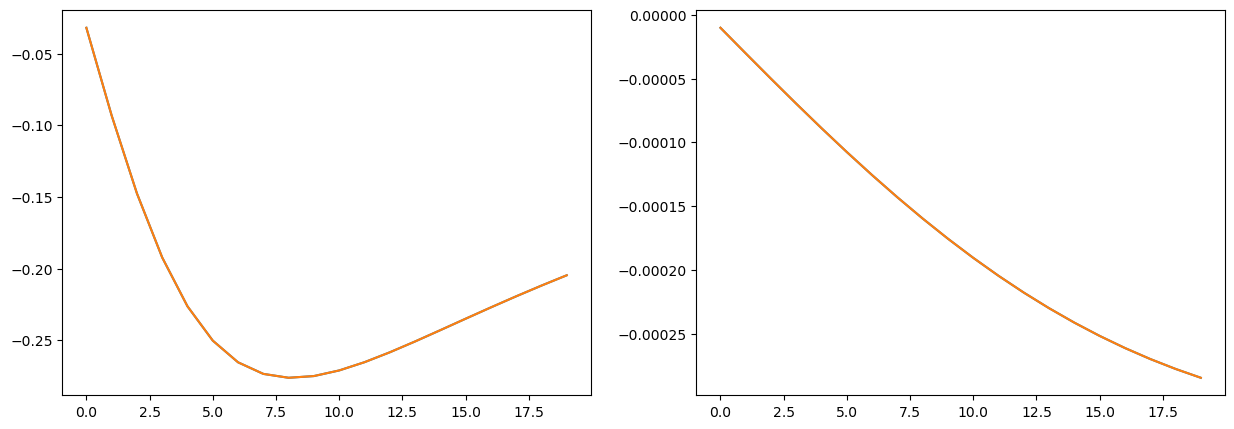

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

PATH_TRAIN = "/gpfs/data/fs72150/springerd/Projects/LuttingerWard_from_ML/data/batch1.hdf5"
bf = h5py.File(PATH_TRAIN, 'r')
print(bf['Set1'].keys())
Bdata = bf["/Set1"]

PATH_TRAIN = "/gpfs/data/fs72150/springerd/Projects/LuttingerWard_from_ML/data/batch_1_new.hdf5"
bf1 = h5py.File(PATH_TRAIN, 'r')
Bdata1 = bf1["/data/30"]
print(Bdata1.shape)

n = 11200
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15,5))
fign = 0 
ax[fign].plot(Bdata["GImp"][n,:20].imag)
ax[fign].plot(Bdata1[n,0,:20].imag)

fign = 1
ax[fign].plot(Bdata["SImp"][n,:20].imag)
ax[fign].plot(Bdata1[n,1,:20].imag)

bf.close()
bf1.close()

In [55]:
# PATH_TRAIN = "../data/batch_1_new.hdf5"
# bf = h5py.File(PATH_TRAIN, 'r')

# print(bf['/data/30/'].shape)

# PATH = "../data/batch_1_new.hdf5"
# bf = h5py.File(PATH, 'r')
# print(bf['/data/30/'].shape)
# # print(bf.keys())
# bf.close()

PATH = "/gpfs/data/fs72150/springerd/Projects/LuttingerWard_from_ML/data/U2c0_b30_N250000.jld2"
bf = h5py.File(PATH, 'r')
print(bf['/Set1/GImp'].shape)
# bf.close()

PATH = "/gpfs/data/fs72150/springerd/Projects/LuttingerWard_from_ML/data/GTrans/U2c0_b30_N250000.hdf5"
bf = h5py.File(PATH, 'r')
print(bf['/metiso/data/30.0'].shape)
print(bf.keys())
bf.close()


(250000, 1000)
(246500, 2, 1000)
<KeysViewHDF5 ['metiso', 'transprox']>
